## Implementación del método DeepSurv

https://github.com/jaredleekatzman/DeepSurv/tree/master

https://github.com/havakv/pycox

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

from pycox.datasets import support
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models.loss import rank_loss_deephit_single

import pycox.models.loss 

import torch # For building the networks 
import torchtuples as tt # Some useful functions
from torch import nn
import torch.nn.functional as F

In [2]:
data = pd.read_parquet('data_deepsurv_corr6.parquet')

In [3]:
data.head()

,edad,cohorte_1,total_corregido,fallecido_ventana,A41,C15,C16,C18,C25,C34,...,J15,J18,J80,J90,J96,grupo_edad_A,grupo_edad_B,grupo_edad_C,grupo_edad_D,grupo_edad_E
6,53,NA,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,61,NA,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,46,ONCOLOGIA ADULTOS,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11,33,NA,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15,85,NA,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# import pandas as pd

# # Crear un DataFrame de ejemplo
# df = pd.DataFrame({'A': [1, 0, 0],
#                    'B': [1, 1, 1],
#                    'C': [0, 1, 0]})

# # Obtener las columnas binarias
# columnas_binarias = df.columns

# # Generar las columnas de interacción
# for i in range(len(columnas_binarias) - 1):
#     for j in range(i + 1, len(columnas_binarias)):
#         columna_interaccion = columnas_binarias[i] + columnas_binarias[j]
#         df[columna_interaccion] = df[columnas_binarias[i]] * df[columnas_binarias[j]]

# print(df)

In [8]:
data.columns

Index(['edad', 'cohorte_1', 'total_corregido', 'fallecido_ventana', 'A41',
       'C15', 'C16', 'C18', 'C25', 'C34', 'C48', 'C50', 'C54', 'C56', 'C61',
       'C64', 'C71', 'C78', 'C90', 'D37', 'D38', 'D43', 'G93', 'I21', 'I50',
       'I67', 'I71', 'J15', 'J18', 'J80', 'J90', 'J96', 'grupo_edad_A',
       'grupo_edad_B', 'grupo_edad_C', 'grupo_edad_D', 'grupo_edad_E'],
      dtype='object')

In [9]:
covariables = ['grupo_edad_A',
       'grupo_edad_B', 'grupo_edad_C', 'grupo_edad_D', 'grupo_edad_E',  'A41',
       'C15', 'C16', 'C18', 'C25', 'C34', 'C48', 'C50', 'C54', 'C56', 'C61',
       'C64', 'C71', 'C78', 'C90', 'D37', 'D38', 'D43', 'G93', 'I21', 'I50',
       'I67', 'I71', 'J15', 'J18', 'J80', 'J90', 'J96','cohorte_1']

In [10]:
df_test = data.sample(frac=0.2)
df_train = data.drop(df_test.index)
df_val = data.sample(frac=0.2)
df_train = data.drop(df_val.index)

In [11]:
cols_std = [] # numeric variables
cols_bin = [ 'grupo_edad_A',
       'grupo_edad_B', 'grupo_edad_C', 'grupo_edad_D', 'grupo_edad_E',  'A41',
       'C15', 'C16', 'C18', 'C25', 'C34', 'C48', 'C50', 'C54', 'C56', 'C61',
       'C64', 'C71', 'C78', 'C90', 'D37', 'D38', 'D43', 'G93', 'I21', 'I50',
       'I67', 'I71', 'J15', 'J18', 'J80', 'J90', 'J96'] # binary variables
cols_cat = [ 'cohorte_1'] # categorical variables

standardize = [([col], StandardScaler()) for col in cols_std]
leave = [(col, None) for col in cols_bin]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to convert data to 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train).astype('float32')
x_val = x_transform(df_val).astype('float32')
x_test = x_transform(df_test).astype('float32')

In [12]:
get_target = lambda df: (df['total_corregido'].values, df['fallecido_ventana'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
#val = x_val, y_val

In [13]:
durations_test, events_test 

(array([6, 1, 1, ..., 1, 3, 2], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [14]:
# Convierte los arreglos NumPy en tensores de PyTorch
tensor_val1 = torch.from_numpy(x_val[0])
tensor_val2 = torch.from_numpy(x_val[1])

x_val_final = torch.hstack((tensor_val1, tensor_val2))

x_val_tf = tt.tuplefy(x_val_final)
print(x_val_final.shape) 

torch.Size([3160, 34])


In [15]:
# Convierte los arreglos NumPy en tensores de PyTorch
tensor_val3 = torch.from_numpy(y_val[0])
tensor_val4 = torch.from_numpy(y_val[1])
y_val_tf = tt.tuplefy(tensor_val3,tensor_val4)

In [16]:
x_val_tf = tt.tuplefy(x_val_final)
y_val_tf = tt.tuplefy(tensor_val3,tensor_val4)

In [17]:
y_val_tf = tt.tuplefy(y_val_tf[0].to(torch.float32), y_val_tf[1].to(torch.float32))

In [18]:
val = x_val_tf, y_val_tf

In [19]:
tensor1 = torch.from_numpy(x_train[0])
tensor2 = torch.from_numpy(x_train[1])
x_train_final = torch.hstack((tensor1, tensor2))

print(x_train_final.shape) 

torch.Size([12638, 34])


In [20]:
tensor3 = torch.from_numpy(y_train[0])
tensor4 = torch.from_numpy(y_train[1])

In [21]:
x_train_tf = tt.tuplefy(x_train_final)
y_train_tf = tt.tuplefy(tensor3,tensor4)

In [22]:
y_train_tf = tt.tuplefy(y_train_tf[0].to(torch.float32), y_train_tf[1].to(torch.float32))

In [23]:
tensor_test1 = torch.from_numpy(x_test[0])
tensor_test2 = torch.from_numpy(x_test[1])
x_test_final = torch.hstack((tensor_test1, tensor_test2))

print(x_test_final.shape) 

torch.Size([3160, 34])


In [24]:
x_train.shapes()[1]

(12638, 1)

In [25]:
in_features = x_test_final.shape[1]
num_nodes = [64,64]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias = output_bias)

In [26]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=34, out_features=64, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): Linear(in_features=64, out_features=1, bias=False)
  )
)

In [27]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay = 0.01, cycle_eta_multiplier = 0.8,
                            cycle_multiplier = 2)

In [28]:
model_2a = CoxPH(net, optimizer ) 

In [29]:
batch_size = 2048

In [30]:
lrfind = model_2a.lr_finder(x_train_tf, y_train_tf, batch_size, tolerance = 50)

C:\Users\juan.canas\.conda\envs\deep_surv\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1420.)
  p.data = p.data.add(-weight_decay * eta, p.data)


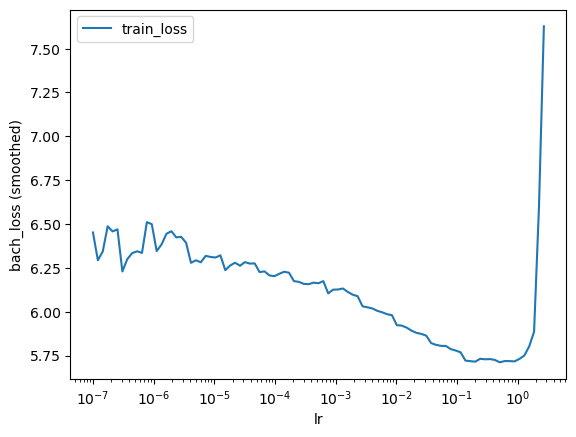

In [31]:
_ = lrfind.plot()

In [32]:
lrfind.get_best_lr()

0.050941380148164093

In [33]:
model_2a.optimizer.set_lr(lrfind.get_best_lr())

In [34]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [35]:
%%time
log = model_2a.fit(x_train_tf, y_train_tf, batch_size, epochs, callbacks, verbose, 
                   val_data = val, val_batch_size = batch_size)

0:	[0s / 0s],		train_loss: 5.8819,	val_loss: 5.4638
1:	[0s / 0s],		train_loss: 5.5130,	val_loss: 5.2700
2:	[0s / 0s],		train_loss: 5.3233,	val_loss: 5.2113
3:	[0s / 0s],		train_loss: 5.2703,	val_loss: 5.0630
4:	[0s / 0s],		train_loss: 5.2127,	val_loss: 5.0303
5:	[0s / 0s],		train_loss: 5.1948,	val_loss: 4.9890
6:	[0s / 0s],		train_loss: 4.9658,	val_loss: 4.9617
7:	[0s / 0s],		train_loss: 5.0131,	val_loss: 4.9740
8:	[0s / 0s],		train_loss: 5.0712,	val_loss: 4.8681
9:	[0s / 0s],		train_loss: 4.9348,	val_loss: 4.8554
10:	[0s / 1s],		train_loss: 4.8860,	val_loss: 4.8476
11:	[0s / 1s],		train_loss: 5.0201,	val_loss: 4.8783
12:	[0s / 1s],		train_loss: 4.7734,	val_loss: 4.8612
13:	[0s / 1s],		train_loss: 5.0392,	val_loss: 4.8520
14:	[0s / 1s],		train_loss: 5.0866,	val_loss: 4.8569
15:	[0s / 1s],		train_loss: 5.0817,	val_loss: 4.8588
16:	[0s / 1s],		train_loss: 4.9952,	val_loss: 4.8957
17:	[0s / 1s],		train_loss: 5.0841,	val_loss: 4.9524
18:	[0s / 1s],		train_loss: 5.0569,	val_loss: 4.9443
19:

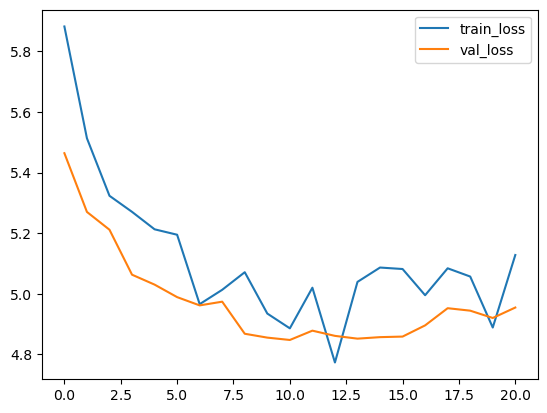

In [36]:
_ = log.plot()

In [37]:
model_2a.partial_log_likelihood(*val).mean()

-5.63483190536499

In [38]:
_ = model_2a.compute_baseline_hazards()

In [39]:
surv = model_2a.predict_surv_df(x_test_final)

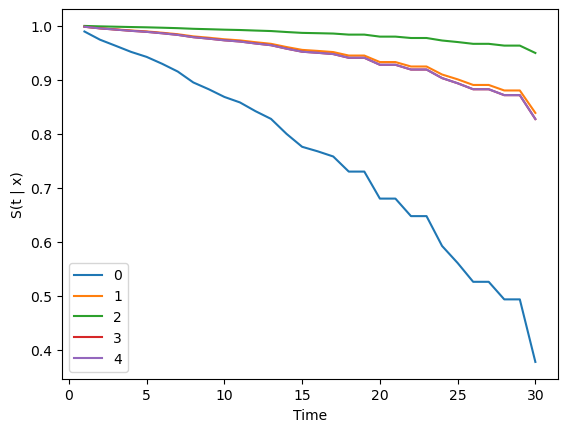

In [40]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [41]:
# Obtener los coeficientes de cada capa
coefficients = []
for name, param in model_2a.net.named_parameters():
    print(name)
    if 'weight' in name:
        coefficients.append(param.squeeze())

net.0.linear.weight
net.0.linear.bias
net.0.batch_norm.weight
net.0.batch_norm.bias
net.1.linear.weight
net.1.linear.bias
net.1.batch_norm.weight
net.1.batch_norm.bias
net.2.weight


In [42]:
for i in range(5):
    print(coefficients[i].shape)

torch.Size([64, 34])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])


In [43]:
hazard_ratios_coef = (coefficients[0].mT.matmul(coefficients[2].mT)).matmul(coefficients[4])

In [44]:
hazard_ratios_coef = torch.exp(hazard_ratios_coef)

In [45]:
coefficients[0].mT.shape

torch.Size([34, 64])

In [46]:
hazard_ratios_coef.detach().numpy().shape

(34,)

In [47]:
len(covariables)

34

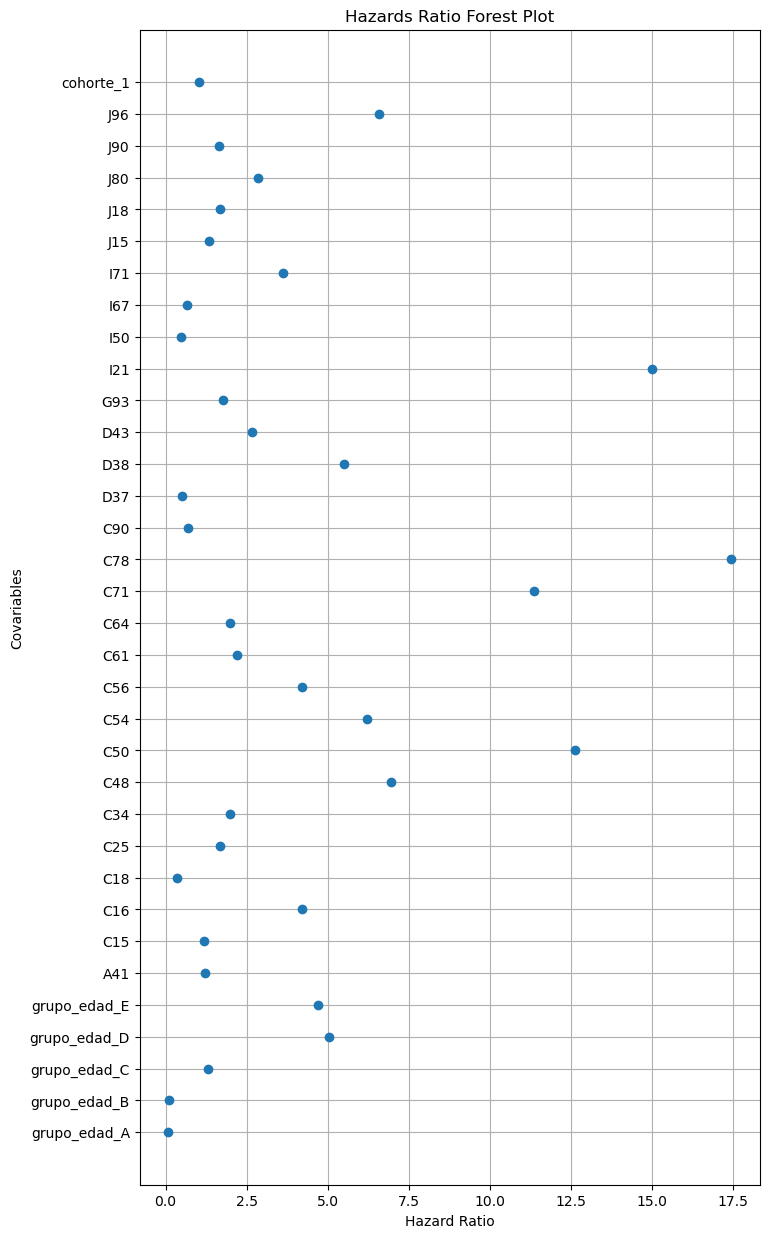

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 15))
plt.errorbar(hazard_ratios_coef.detach().numpy(), range(len(covariables)), xerr=None, fmt='o')
plt.yticks(range(len(covariables)), covariables)
plt.xlabel('Hazard Ratio')
plt.ylabel('Covariables')
plt.title('Hazards Ratio Forest Plot')
plt.grid(True)
plt.show()

In [49]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [50]:
ev.concordance_td()

0.8692956878363322

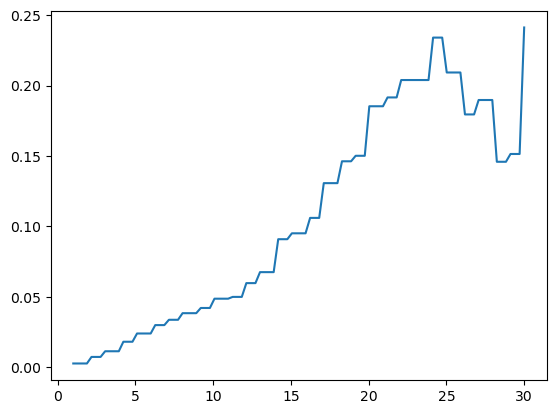

In [51]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

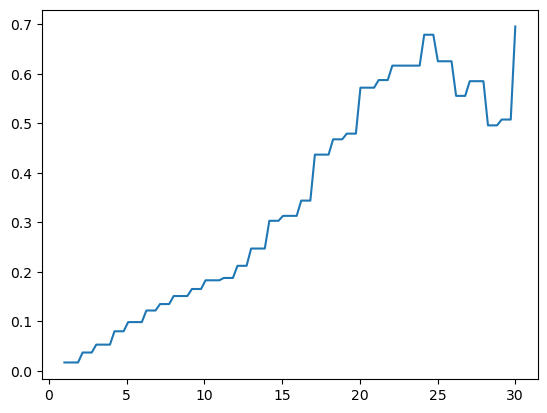

In [52]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.nbll(time_grid).plot()

In [53]:
ev.integrated_brier_score(time_grid)

0.10569787041577886

In [54]:
ev.integrated_nbll(time_grid)

0.34175846957775213